<a href="https://colab.research.google.com/github/psimanaitis/pix2html/blob/main/cptr_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset import and its preprocessing

In [ ]:
%%capture

!pip install tf-models-official
!pip install tensorflow-addons

import tensorflow as tf
import tensorflow_addons as tfa
import time, os
import numpy as np
import json
from tensorboard.plugins.hparams import api as hp


tf.keras.utils.get_file('pix2html.zip', cache_subdir=os.path.abspath('.'), origin = 'https://raw.githubusercontent.com/psimanaitis/pix2html/main/dataset/pix2html.zip', extract = True)
tf.keras.utils.get_file('pix2code.zip', cache_subdir=os.path.abspath('.'), origin = 'https://raw.githubusercontent.com/psimanaitis/pix2html/main/dataset/pix2code.zip', extract = True)


!pip install wandb -qqq
import wandb

In [ ]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
def find_max_list(list):
    list_len = [len(i) for i in list]
    return max(list_len)

def get_dataset_vectors(html_entries, tokenizer, input_path):
    sequences = []
    images = []
    for x in range(len(html_entries)):
            entry = html_entries[x]
            full_input_path =  input_path + entry['id'] + '.jpeg'
            images.append(full_input_path)
            # TODO add start end tokens
            sequences.append(entry['content'])

    return sequences, images

def read_images(images, dimensions=224):
    parsed = []
    for image in images:
        img = tf.io.read_file(image)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (dimensions, dimensions))
        img =  tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255)(img)    
        parsed.append(img)
    
    return parsed


def load_dataset(dataset_name):
    #dataset_name pix2html | pix2code
    input_path = dataset_name + '/resized/'

    with open(dataset_name + '/tokens.json', 'r') as f:
        tokens = json.load(f)

    tokens.append('<start>')
    tokens.append('<end>')
    tokens.append('<unk>')      

    top_k = len(tokens) + 1
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, oov_token="<unk>", filters='', split=" ")
    tokenizer.fit_on_texts(tokens)
    tokenizer.word_index['<pad>'] = 0
    tokenizer.index_word[0] = '<pad>'

    with open(dataset_name + '/train-html.json', 'r') as f:
        train_entries = json.load(f)

    with open(dataset_name + '/test-html.json', 'r') as f:
        test_entries = json.load(f)


    train_sequences, train_images = get_dataset_vectors(train_entries, tokenizer, input_path)
    validate_sequences, validate_images = get_dataset_vectors(test_entries, tokenizer, input_path)

    tokenized_train = tokenizer.texts_to_sequences(train_sequences)
    tokenized_validate = tokenizer.texts_to_sequences(validate_sequences)
    maxlen = max([find_max_list(list = tokenized_train), find_max_list(list = tokenized_validate)])

    train_sequences = tokenizer.texts_to_sequences(train_sequences)
    train_sequences = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, padding='post', maxlen=maxlen)

    validate_sequences = tokenizer.texts_to_sequences(validate_sequences)
    validate_sequences = tf.keras.preprocessing.sequence.pad_sequences(validate_sequences, padding='post', maxlen=maxlen)

    train_images = read_images(train_images)
    validate_images = read_images(validate_images)

    return train_sequences, train_images, validate_sequences, validate_images, top_k, tokenizer

# decoder inputs use the previous target as input
# remove START_TOKEN from targets
def process_dataset(image, html, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((
        {
            'inputs': image,
            'dec_inputs': html[:, :-1]
        },
        {
            'outputs': html[:, 1:]
        },
    ))
    dataset = dataset.cache()
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset    

# The model

I am trying to implement this model

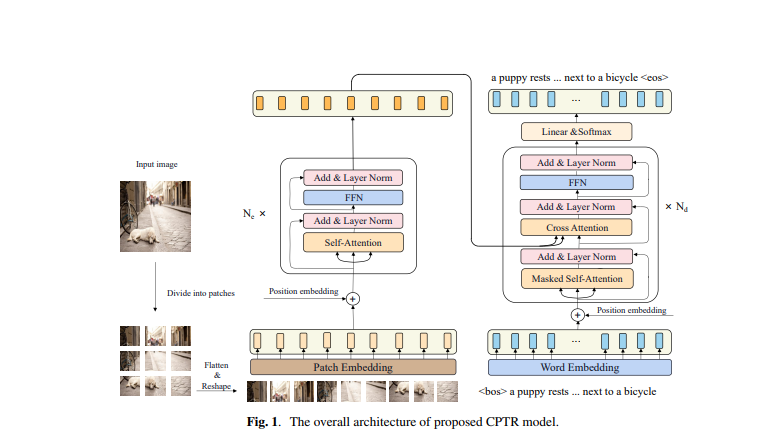

In [ ]:
import tensorflow_addons as tfa
from official.nlp.transformer.ffn_layer import FeedForwardNetwork
from official.nlp.modeling.layers.position_embedding import RelativePositionEmbedding

def encoder_layer(d_model=512, num_heads=8, dropout=0.1, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # Self attention 
  attention = tf.keras.layers.MultiHeadAttention(key_dim=d_model, num_heads=num_heads, dropout=dropout, output_shape=d_model)(inputs, inputs, inputs, attention_mask=None, return_attention_scores=False)

  # Add & Norm 
  attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

  # Feed forward  
  outputs = tf.keras.layers.Dense(units=d_model, activation=tfa.activations.gelu)(attention)
  outputs = tf.keras.layers.Dense(units=d_model, activation=tfa.activations.gelu)(outputs)

  # Add & Norm 
  outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(inputs=[inputs], outputs=outputs, name=name)

def encoder( d_model=512, layers=1, patch_size=16, image_size=224, num_heads=8, dropout=0.1, batch_size=25, channels=3, name="decoder"):
    # sanity check
    assert  d_model % num_heads == 0
    assert  image_size % patch_size == 0

    inputs = tf.keras.Input((224,224,3), name="inputs")

     # Image to patches
    patches = tf.image.extract_patches(
        images=inputs,
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )
    
    # Embed patches
    # patches = tf.reshape(patches, [batch_size, -1, channels * patch_size ** 2])
    patches = tf.keras.layers.Flatten()(patches) # Flatten
    patches = tf.keras.layers.Reshape((-1, channels * patch_size ** 2))(patches) # Reshape
    embeddings = tf.keras.layers.Dense(d_model, activation=tfa.activations.gelu)(patches)

    # Add positional encoding of patches
    embeddings += RelativePositionEmbedding(hidden_size=d_model)(embeddings)


    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(layers):
        outputs = encoder_layer(
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs])
    
    return tf.keras.Model(inputs=[inputs], outputs=outputs, name=name)


def decoder_layer(d_model=512, heads=8, dropout=0.01, name="decoder_layer"):
    inputs = tf.keras.Input((None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input((1, None, None), name="look_ahead_mask")

    attn1 = tf.keras.layers.MultiHeadAttention(value_dim=d_model, key_dim=d_model, num_heads=heads, dropout=dropout, output_shape=d_model, name='')(inputs, inputs, inputs, look_ahead_mask, False)
    out1 = tf.keras.layers.LayerNormalization(epsilon=1e-6, name='add_and_norm_1')(attn1 + inputs)

    attn2 = tf.keras.layers.MultiHeadAttention(value_dim=d_model, key_dim=d_model, num_heads=heads, dropout=dropout, output_shape=d_model)(out1, enc_outputs, enc_outputs, None, False)
    out2 = tf.keras.layers.LayerNormalization(epsilon=1e-6, name='add_and_norm_2')(attn2 + out1)

    outputs = tf.keras.layers.Dense(units=d_model, activation=tfa.activations.gelu)(attn2)
    outputs = tf.keras.layers.Dense(units=d_model, activation=tfa.activations.gelu)(outputs)

    out3 = tf.keras.layers.LayerNormalization(epsilon=1e-6, name='add_and_norm_3')(outputs + out2)

    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask], outputs=out3, name=name)        


def decoder(d_model=512,heads=8, target_vocab_size=80, layers=8, dropout=0.1, name="decoder"):
    inputs = tf.keras.Input((None,), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')

    embeddings = tf.keras.layers.Embedding(target_vocab_size , d_model, name='output_embeding')(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    pos_encoding = RelativePositionEmbedding(hidden_size=d_model)(embeddings)
    embeddings = embeddings + pos_encoding

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(layers):
        outputs = decoder_layer(d_model=d_model, heads=heads, dropout=dropout, name='decoder_layer_{}'.format(i), )(inputs=[outputs, enc_outputs, look_ahead_mask])

    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask], outputs=outputs, name=name)


def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  return mask[:, tf.newaxis, tf.newaxis, :]

def create_masks_decoder(x, training):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

def transformer(vocab_size=88, d_model=512, heads=8, layers=1, dropout=0.01, patch_size=16, image_size=224, name='CPTR'):
    inputs = tf.keras.Input((224,224,3), name="inputs")
    dec_inputs = tf.keras.Input((None,), name="dec_inputs")


    dec_mask = tf.keras.layers.Lambda(create_masks_decoder, output_shape=(1, None, None), name='look_ahead_mask')(dec_inputs)

    enc_outputs = encoder(
         d_model=d_model, 
         layers=layers, 
         patch_size=patch_size,
         image_size=image_size,
         num_heads=heads, 
         dropout=0.1, 
         batch_size=25,
         channels=3,
         name="encoder",
    )(inputs=[inputs])


    dec_outputs = decoder(target_vocab_size=vocab_size, d_model=d_model, heads=heads, layers=layers, dropout=dropout)(inputs=[dec_inputs, enc_outputs, dec_mask])

    outputs = tf.keras.layers.Dense(vocab_size, activation='softmax', name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)        

# Training

In [ ]:
train_sequences, train_images, validate_sequences, validate_images, top_k, tokenizer = load_dataset('pix2code')

MAX_LENGTH = len(train_sequences[0])

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

def other_accuracy(real, pred):
  casted = tf.cast(tf.argmax(pred, axis=2), tf.float32)
  accuracies = tf.equal(real,  casted)
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)
  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)

  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)


def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(y_true, y_pred)
  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)


In [ ]:
from official.nlp.optimization import create_optimizer
from wandb.keras import WandbCallback

batch_size = 32

train_dataset = process_dataset(train_images, train_sequences, batch_size)
validate_dataset = process_dataset(validate_images, validate_sequences , batch_size)


epochs = 10
train_data_size = 1500
                    
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)
initial_learning_rate=2e-5

optimizer = create_optimizer(init_lr=initial_learning_rate,
                                num_train_steps=num_train_steps,
                                num_warmup_steps=warmup_steps,
                                end_lr=0.0,
                                optimizer_type='adamw')


model = transformer(d_model = 1024,
                    vocab_size = top_k,
                    layers = 2,
                    dropout = 0.01,
                    heads = 4,
                    name = 'transformer')

run = wandb.init(project='pix2code', reinit=True,)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy, other_accuracy])                           
history = model.fit(train_dataset, validation_data=validate_dataset, epochs=epochs, verbose=1, callbacks=[WandbCallback()])

run.finish()

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/activations/gelu.py:81: UserWarning: Default value of `approximate` is changed from `True` to `False`
  "Default value of `approximate` is changed from `True` to `False`"


Epoch 1/10
47/47 [==============================] - 38s 630ms/step - loss: 1.5158 - accuracy: 0.1081 - other_accuracy: 0.1848 - val_loss: 0.9448 - val_accuracy: 0.2679 - val_other_accuracy: 0.4633


wandb: ERROR Can't save model, h5py returned error: Unable to create link (name already exists)


Epoch 2/10
47/47 [==============================] - 29s 607ms/step - loss: 0.7161 - accuracy: 0.3507 - other_accuracy: 0.5998 - val_loss: 0.2657 - val_accuracy: 0.4751 - val_other_accuracy: 0.8221
Epoch 3/10
47/47 [==============================] - 28s 607ms/step - loss: 0.2036 - accuracy: 0.5050 - other_accuracy: 0.8635 - val_loss: 0.0338 - val_accuracy: 0.5668 - val_other_accuracy: 0.9806
Epoch 4/10
47/47 [==============================] - 29s 607ms/step - loss: 0.0315 - accuracy: 0.5747 - other_accuracy: 0.9826 - val_loss: 0.0182 - val_accuracy: 0.5719 - val_other_accuracy: 0.9895
Epoch 5/10
47/47 [==============================] - 28s 606ms/step - loss: 0.0186 - accuracy: 0.5784 - other_accuracy: 0.9890 - val_loss: 0.0112 - val_accuracy: 0.5747 - val_other_accuracy: 0.9944
Epoch 6/10
47/47 [==============================] - 28s 606ms/step - loss: 0.0109 - accuracy: 0.5812 - other_accuracy: 0.9938 - val_loss: 0.0053 - val_accuracy: 0.5776 - val_other_accuracy: 0.9994
Epoch 7/10
47/4

epoch,9
loss,0.00283
accuracy,0.58638
other_accuracy,0.99921
val_loss,0.00146
val_accuracy,0.57793
val_other_accuracy,0.99992
_runtime,304
_timestamp,1615663903
_step,9
best_val_loss,0.00146


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▂▁▁▁▁▁▁▁
accuracy,▁▅▇███████
other_accuracy,▁▅▇███████
val_loss,█▃▁▁▁▁▁▁▁▁
val_accuracy,▁▆████████
val_other_accuracy,▁▆████████
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


# Demonstrate working model

In [ ]:
def predict(model, tokenizer, image_tensor, html=[]):
    start_token = 2 
    end_token = 78

    if (len(html) == 0):
        html = tf.expand_dims([start_token], 0)

    reshaped_image = tf.expand_dims(image_tensor, axis=0)
    html = tf.expand_dims([start_token], 0)

    reshaped_image = tf.expand_dims(image_tensor, axis=0)
    prediction = model(inputs=[reshaped_image, html], training=False)

    prediction = prediction[:, -1:, :]
    prediction = tf.cast(tf.argmax(prediction, axis=-1), tf.int32)
    i = 0
    while (tf.equal(prediction, end_token) == False and i < 20):
        print('passed to model for next token prediction', html)
        prediction = model(inputs=[reshaped_image, html], training=False)
        prediction = prediction[:, -1:, :]
        prediction = tf.cast(tf.argmax(prediction, axis=-1), tf.int32)
        html = tf.concat([html, prediction], axis=-1)
        result1 = tf.squeeze(html, axis=0).numpy()
        result = ' '.join([tokenizer.index_word[i] for i in result1 ])
        print(result)
        html = tf.expand_dims(result1, 0)
        i += 1 

    return tf.squeeze(html, axis=0)

from IPython.core.display import display, HTML
from google.colab import files

def add_file():
    uploaded = files.upload()
    return list(uploaded.keys())[0]


uploaded_image = add_file()
uploade_image_features = read_images([uploaded_image])[0]

predicted = predict(model, tokenizer, uploade_image_features)
predicted = predicted.numpy()
print(predicted)

html = ' '.join([tokenizer.index_word[i] for i in predicted])
print(html)
display(HTML(html))

Saving 0B660875-60B4-4E65-9793-3C7EB6C8AFD0.gui.jpeg to 0B660875-60B4-4E65-9793-3C7EB6C8AFD0.gui.jpeg


/usr/local/lib/python3.7/dist-packages/tensorflow_addons/activations/gelu.py:81: UserWarning: Default value of `approximate` is changed from `True` to `False`
  "Default value of `approximate` is changed from `True` to `False`"


passed to model for next token prediction tf.Tensor([[2]], shape=(1, 1), dtype=int32)
header {
passed to model for next token prediction tf.Tensor([[2 3]], shape=(1, 2), dtype=int32)
header { {
passed to model for next token prediction tf.Tensor([[2 3 3]], shape=(1, 3), dtype=int32)
header { { row
passed to model for next token prediction tf.Tensor([[2 3 3 8]], shape=(1, 4), dtype=int32)
header { { row row
passed to model for next token prediction tf.Tensor([[2 3 3 8 8]], shape=(1, 5), dtype=int32)
header { { row row row
passed to model for next token prediction tf.Tensor([[2 3 3 8 8 8]], shape=(1, 6), dtype=int32)
header { { row row row row
passed to model for next token prediction tf.Tensor([[2 3 3 8 8 8 8]], shape=(1, 7), dtype=int32)
header { { row row row row row
passed to model for next token prediction tf.Tensor([[2 3 3 8 8 8 8 8]], shape=(1, 8), dtype=int32)
header { { row row row row row row
passed to model for next token prediction tf.Tensor([[2 3 3 8 8 8 8 8 8]], shape=(1, 9

In [ ]:
model.summary()

In [ ]:
def plot_model(model, file_name='model.png'):
    return tf.keras.utils.plot_model(model, file_name, show_shapes=True, rankdir='TB', dpi=80, show_dtype=True, expand_nested=True)  


sample_encoder_layer = encoder_layer(d_model=512, num_heads=8, dropout=0.1, name="sample_encoder_layer")

# plot_model(sample_encoder_layer)    

sample_encoder = encoder(
    patch_size=16,
    image_size=224, 
    d_model=512,
    num_heads=8,
    dropout=0.1, 
    batch_size=25, 
    channels=3,
    name="sample_encoder_layer")


# plot_model(sample_encoder)

sample_decoder_layer = decoder_layer(
    d_model=512,
    heads=8,
    dropout=0.01,
    name="sample_encoder_layer")

# plot_model(sample_decoder_layer)  



sample_decoder = decoder(
    d_model=512,
    heads=8, 
    target_vocab_size=80, 
    layers=8,
    dropout=0.1,
    name="sample_decoder"
    )

# plot_model(sample_decoder_layer)    


sample_transformer = transformer(vocab_size=88, 
                                 d_model=512,
                                 heads=8, 
                                 layers=1, 
                                 dropout=0.01, 
                                 patch_size=16,
                                 image_size=224, 
                                 name='CPTR')     

# plot_model(sample_transformer)   